In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import fasttext

import gensim
from gensim import corpora, models, similarities

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [6]:
X = df["text"]
y = df["aspect_polarity"]

In [9]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [12]:
train_df, valid_df, test_df = train_validate_test_split(df, split_size=0.9)

In [13]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [14]:
train_df["label_format"] = 0
for i in range(len(train_df)):
    train_df.label_format[i] = "__label__" + str(train_df["aspect_polarity"][i]) + " " + str(train_df["text"][i])

/tmp/ipykernel_228050/789492946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label_format"] = 0
/tmp/ipykernel_228050/789492946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.label_format[i] = "__label__" + str(train_df["aspect_polarity"][i]) + " " + str(train_df["text"][i])


In [15]:
valid_df["label_format"] = 0
for i in range(len(valid_df)):
    valid_df.label_format[i] = "__label__" + str(valid_df["aspect_polarity"][i]) + " " + str(valid_df["text"][i])

/tmp/ipykernel_228050/3067820444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["label_format"] = 0
/tmp/ipykernel_228050/3067820444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df.label_format[i] = "__label__" + str(valid_df["aspect_polarity"][i]) + " " + str(valid_df["text"][i])


In [16]:
test_df["label_format"] = 0
for i in range(len(test_df)):
    test_df.label_format[i] = "__label__" + str(test_df["aspect_polarity"][i]) + " " + str(test_df["text"][i])

/tmp/ipykernel_228050/401181974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label_format"] = 0
/tmp/ipykernel_228050/401181974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.label_format[i] = "__label__" + str(test_df["aspect_polarity"][i]) + " " + str(test_df["text"][i])


In [17]:
train_df.label_format.to_csv("fasttext_train.txt", index=None, header=None)
valid_df.label_format.to_csv("fasttext_valid.txt", index=None, header=None)
test_df.label_format.to_csv("fasttext_test.txt", index=None, header=None)

In [18]:
model5_train_start = time.time()
fasttext_model = fasttext.train_supervised("fasttext_train.txt", epoch=50, lr=0.05, label_prefix="__label__", dim=300)
model5_train_time = time.time() - model5_train_start
print(f"FastText Train Time = {model5_train_time:.4f}")

Read 2M words
Number of words:  103172
Number of labels: 3
Progress:  99.0% words/sec/thread: 1071690 lr:  0.000510 avg.loss:  0.299367 ETA:   0h 0m 0s

FastText Train Time = 13.1039


Progress: 100.0% words/sec/thread: 1065392 lr:  0.000000 avg.loss:  0.298017 ETA:   0h 0m 0s


In [19]:
def predict_fasttext(row):
    pred = fasttext_model.predict(row)[0][0].replace("__label__", "")
    return int(pred)

In [24]:
model5_test_start = time.time()
fasttext_pred_test = [predict_fasttext(test) for test in test_df.label_format]
model5_test_time = time.time() - model5_test_start
print(f"FastText Test Time = {model5_test_time:.4f}")

FastText Test Time = 0.0824


In [28]:
fasttext_pred_train = [predict_fasttext(train) for train in train_df.label_format]
fasttext_train_score = accuracy_score(fasttext_pred_train, train_df.aspect_polarity)
fasttext_test_score = accuracy_score(fasttext_pred_test, test_df.aspect_polarity)
print(f"FastText Train Score = {fasttext_train_score * 100:.4f}%")
print(f"FastText Test Score = {fasttext_test_score * 100:.4f}%")

FastText Train Score = 95.9091%
FastText Test Score = 83.6704%


In [29]:
fasttext_precision_score = precision_score(test_df.aspect_polarity, fasttext_pred_test, average="macro")
fasttext_f1_score = f1_score(test_df.aspect_polarity, fasttext_pred_test, average="macro")
fasttext_recall_score = recall_score(test_df.aspect_polarity, fasttext_pred_test, average="macro")
fasttext_accuracy_score = accuracy_score(test_df.aspect_polarity, fasttext_pred_test)

print(f"FastText Precision Score = {fasttext_precision_score * 100:.4f}%")
print(f"FastText F1 Score = {fasttext_f1_score * 100:.4f}%")
print(f"FastText Recall Score = {fasttext_recall_score * 100:.4f}%")
print(f"FastText Accuracy Score = {fasttext_accuracy_score * 100:.4f}%")

FastText Precision Score = 73.4314%
FastText F1 Score = 73.0349%
FastText Recall Score = 72.6645%
FastText Accuracy Score = 83.6704%


In [30]:
print(classification_report(test_df.aspect_polarity, fasttext_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87      4508
     Neutral       0.50      0.48      0.49       421
    Positive       0.83      0.83      0.83      3179

    accuracy                           0.84      8108
   macro avg       0.73      0.73      0.73      8108
weighted avg       0.84      0.84      0.84      8108



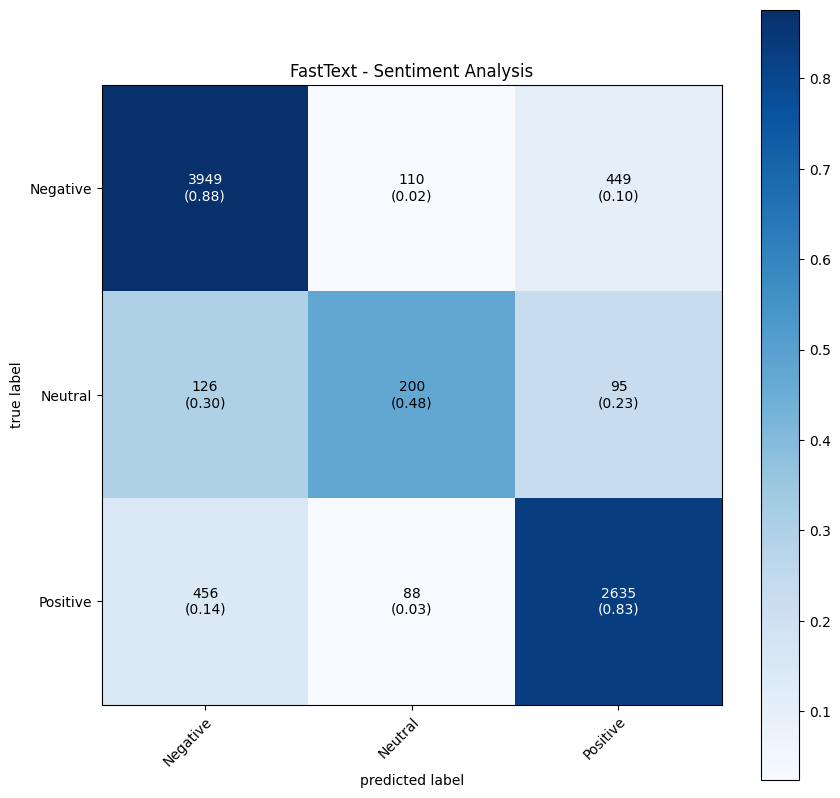

In [31]:
fasttext_cm = confusion_matrix(test_df.aspect_polarity, fasttext_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=fasttext_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("FastText - Sentiment Analysis")
plt.savefig("./output/fasttext.png")
plt.show()